In [1]:
!pip install -q datasets==2.21.0 requests torch peft bitsandbytes transformers==4.43.1 trl accelerate sentencepiece tiktoken matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git@fix-to-int8
!pip install -q datasets
!pip install -q einops

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.12.2 requires transformers<4.47.0, but you have transformers 4.50.0.dev0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × git checkout -q fix-to-int8 did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q fix-to-int8 did not run successfully.
│ exit code: 1
╰─> See above for output.

note: T

In [3]:
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.1/468.1 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [34]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
import wandb
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [37]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "zeush2x7"

DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182

RUN_NAME = "2025-03-05_17.33.50"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

QUANT_4_BIT  = True



GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [38]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "yellow"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [19]:
FINETUNED_MODEL

'zeush2x7/pricer-2025-03-05_17.33.50'

In [11]:
hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential = False)

In [12]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19356 [00:00<?, ? examples/s]

In [13]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nDC Direct Batman Black and White Statue: Batman Arkham Asylum\nFrom the Manufacturer\nSculpted by Dave Cortes. From within the walls of Arkham Asylum, The Joker orchestrates the most elaborate scheme of his career: create an unstoppable army of Bane-like creatures to take over Gotham City. Only Batman, using an amalgam of detective, combat and stealth skills, can end his arch-nemesis’ plans. This very special Batman Black and White statue was developed using actual character designs from the best-selling game Batman: Arkham Asylum, current holder of the Guinness World Record for “Most Critically Acclaimed Superhero Game Ever,” and the winner of several industry game awards. This statue based on the video game design measures approximately 7.25” high x\n\nPrice is $',
 'price': 300.0}

In [14]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=QUANT_4_BIT,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code = True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_size = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",

)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint()/1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [21]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [24]:
def extract_price(s):
  if "Price is $" in s:
    contents = s.split("Price is $")[1]
    contents = contents.replace(',', '')
    match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
    return float(match.group()) if match else 0
  return 0

In [25]:
extract_price("Price is $778.34 for a tv set")

778.34

In [27]:
def model_predict(prompt):
  set_seed(42)
  inputs = tokenizer.encode(promppt, return_tensors="pt").to("cuda")
  attention_mask = torch.ones(inputs.shape, device ="cuda")
  outputs = fine_tuned_model.generate(inputs, attention_mask= attention_mask, max_new_tokens=3, num_return_sequences=1)
  response = tokenizer.decode(outputs[0])
  return extract_price(response)

In [35]:
top_K = 3
def improved_model_predict(prompt, device="cuda"):
  set_seed(42)
  inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
  attention_mask = torch.ones(inputs.shape, device= device)
  with torch.no_grad():
    outputs = fine_tuned_model(inputs, attention_mask = attention_mask)
    next_token_logits = outputs.logits[:,-1,:].to('cpu')

  next_token_probs = F.softmax(next_token_logits, dim = -1)
  top_prob, top_token_id = next_token_probs.topk(top_K)
  prices, weights = [],[]
  for i in range(top_K):
    predicted_token = tokenizer.decode(top_token_id[0][i])
    probability = top_prob[0][i]
    try:
      result = float(predicted_token)
    except ValueError as e:
      result = 0.0
    if result>0:
      prices.append(result)
      weights.append(probability)
  if not prices:
    return 0.0, 0.0
  total = sum(weights)
  weighted_prices = [price * weight/ total for price, weight in zip(prices, weights)]
  return sum(weighted_prices).item()




1: Guess: $138.38 Truth: $300.00 Error: $161.62 SLE: 0.59 Item: DC Direct Batman Bla...
2: Guess: $264.50 Truth: $219.00 Error: $45.50 SLE: 0.04 Item: PocketBook Era E-Rea...
3: Guess: $177.25 Truth: $267.74 Error: $90.49 SLE: 0.17 Item: Auto Rim Shop - Bran...
4: Guess: $321.25 Truth: $140.81 Error: $180.44 SLE: 0.67 Item: NavePoint 500ft in W...
5: Guess: $12.03 Truth: $45.99 Error: $33.96 SLE: 1.65 Item: 4 Pack Corner Degree...
6: Guess: $150.12 Truth: $222.78 Error: $72.66 SLE: 0.15 Item: Cloyes Timing Chain
...
7: Guess: $25.39 Truth: $9.99 Error: $15.40 SLE: 0.77 Item: CMS 2GB DDR3 8500 No...
8: Guess: $724.00 Truth: $798.00 Error: $74.00 SLE: 0.01 Item: ASUS 2020 Newest Viv...
9: Guess: $22.78 Truth: $35.99 Error: $13.21 SLE: 0.20 Item: Yatchen Leather Case...
10: Guess: $262.75 Truth: $165.06 Error: $97.69 SLE: 0.21 Item: Alter Oboro Muramasa...
11: Guess: $202.25 Truth: $191.62 Error: $10.63 SLE: 0.00 Item: Power Stop Autospeci...
12: Guess: $360.50 Truth: $177.49 Error: $183.

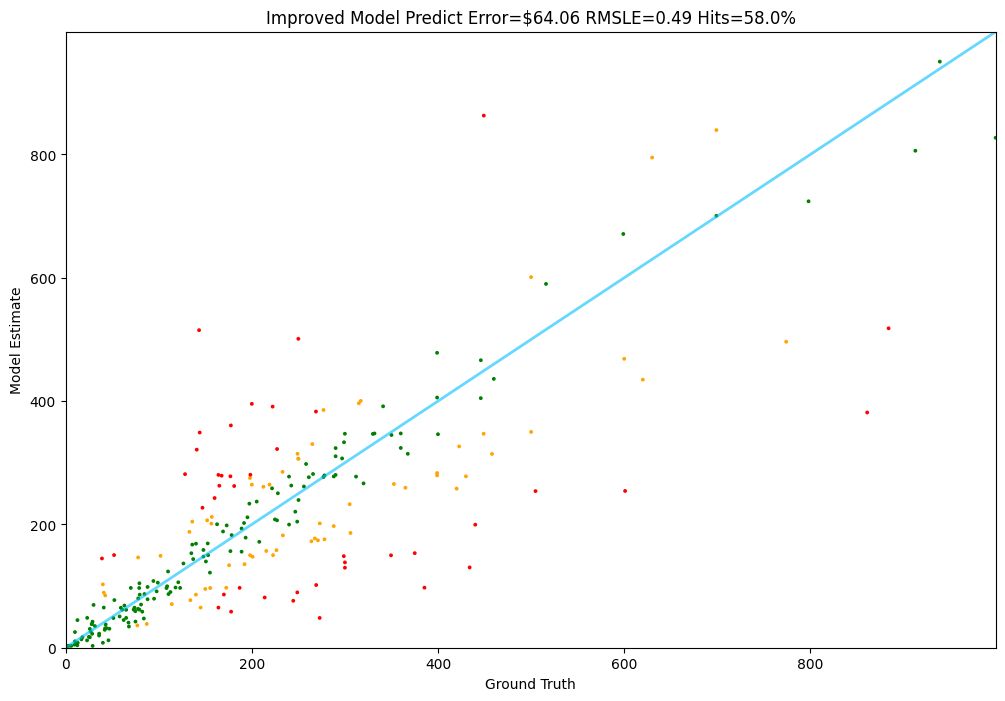

In [39]:
Tester.test(improved_model_predict,  test)